In [7]:
import numpy as np
import numpy.linalg as lin
from scipy.integrate import ode
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy.random as ran
import time
from matplotlib import rcParams
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.family': 'sans-serif',
         'text.usetex': True}
rcParams.update(params)
%matplotlib notebook

In [61]:
class disc_cont_model:
    
    def __init__(self,L,N,dt,init_rho,init_agents,tmax):
        self.L = L
        self.N = N
        self.dt = dt
        #self.W11 = W11
        self.dx = L/N
        self.dy = L/N
        self.tmax = tmax
        self.chalf_x = np.linspace(-L,L,int(2*N+1))
        self.cspan_x = np.linspace(-L + self.dx/2, L - self.dx/2, int(2*N))
        self.chalf_y = np.linspace(-L,L,int(2*N+1))
        self.cspan_y = np.linspace(-L + self.dy/2, L - self.dy/2, int(2*N))
        self.X, self.Y = np.meshgrid(self.cspan_x,self.cspan_y)
        self.rho = [init_rho]
        self.agents = [init_agents]
        self.rho_ex = [np.concatenate([x for x in init_rho])]
        self.Fr = 1
        self.Rr = 20
        self.Ra = 60
        self.Fa21 = 0.0038
        self.Fa12 = 0.203
        self.kint_dens = int(self.Ra/self.dx + .5)
        #self.W_mat = np.array([[W(x-self.X,y-self.Y) for x in self.cspan_x] for y in self.cspan_y])
    
    def boxnum_dens(self,x):
        x1, x2 = x[0] + self.L, x[1] + self.L
        i = max([min([2*self.N - 1, int(x1/self.dx)]),0])
        j = max([min([2*self.N - 1, int(x2/self.dx)]),0])
        return i,j
    
    def H21(self,x1,x2):
        x = np.array([x1,x2])
        h1 = -2*self.Fr/self.Rr*x*(lin.norm(x) < self.Rr/2)
        h2 = (2*self.Fr/self.Rr*lin.norm(x) - 2*self.Fr)*x/lin.norm(x)*(lin.norm(x) < self.Rr)*(lin.norm(x) >= self.Rr/2)
        h3 = -4*self.Fa21*(lin.norm(x)-self.Rr)*(lin.norm(x)-self.Ra)*x/lin.norm(x)/(self.Rr - self.Ra)**2*(lin.norm(x) < self.Ra)*(lin.norm(x) > self.Rr)
        return h1 + h2 + h3
    
    # this part is not complete -------------------
    def H12(self,x1,x2):
        x = np.array([x1,x2])
        h1 = -2*self.Fr/self.Rr*x*(lin.norm(x) < self.Rr/2)
        h2 = (2*self.Fr/self.Rr*lin.norm(x) - 2*self.Fr)*x/lin.norm(x)*(lin.norm(x) < self.Rr)*(lin.norm(x) >= self.Rr/2)
        h3 = -4*self.Fa12*(lin.norm(x)-self.Rr)*(lin.norm(x)-self.Ra)*x/lin.norm(x)/(self.Rr - self.Ra)**2*(lin.norm(x) < self.Ra)*(lin.norm(x) > self.Rr)
        return h1 + h2 + h3
    #-----------------------
    
    def splitter(self,rho_expanded):
        return np.array(np.split(rho_expanded,2*self.N))
    
    def disc_entropy(self,f):
        return f  #+ np.array([[np.sum(np.multiply(w,f)) for w in ww] for ww in self.W_mat])*self.dx*self.dy
    # commented part is the convolution term for the density W*rho
    
    def velocities_x(self,h):
        return -(h[1:,:]-h[:-1,:])/self.dx
    
    def velocities_y(self,h):
        return -(h[:,1:]-h[:,:-1])/self.dy
    
    def flux_x(self,v,g):
        zero_vec = np.zeros(v.shape)
        F = g[:-1,:]*np.maximum(v,zero_vec) + g[1:,:]*np.minimum(v,zero_vec)
        #F = (g[:-1,:] + g[1:,:])/2*v
        return np.concatenate([[np.zeros(len(F[0]))],F,[np.zeros(len(F[0]))]])
    
    def flux_y(self,v,g):
        zero_vec = np.zeros(v.shape)
        F = g[:,:-1]*np.maximum(v,zero_vec) + g[:,1:]*np.minimum(v,zero_vec)
        #F = (g[:,:-1] + g[:,1:])/2*v
        return np.transpose(np.concatenate([[np.zeros(len(F))],np.transpose(F),[np.zeros(len(F))]]))
    
    def grad_rho(self,t,p_expanded):
        p = self.splitter(p_expanded)
        h = self.disc_entropy(p)
        # not complete yet -------------
        #vx_leaders = np.zeros((2*N - 1,2*N))
        #vy_leaders = np.zeros((2*N,2*N - 1))
        #for x in self.agents[-1]:
            #i,j = self.boxnum_dens(x)
            #imin, imax = max(i - self.kint_dens, 0), min(2*self.N - 1, i + self.kint_dens) + 1
            #jmin, jmax = max(j - self.kint_dens, 0), min(2*self.N - 2, j + self.kint_dens) + 1
            #vx_leaders[jmin:jmax, imin:imax] += np.array([[self.H12(x[0] - x1 + self.dx/2,x[1] - x2)[1] for x1 in self.cspan_x[imin:imax]] for x2 in self.cspan_y[jmin:jmax]])
            #imax = min(2*N - 2, i + self.kint_dens) + 1
            #jmax = min(2*N - 1, j + self.kint_dens) + 1
            #vy_leaders[jmin:jmax, imin:imax] += np.array([[self.H21(x[0] - x1,x[1] - x2 + self.dx/2)[0] for x1 in self.cspan_x[imin:imax]] for x2 in self.cspan_y[jmin:jmax]])
        #---------------------------------
        Fx = self.flux_x(self.velocities_x(h),p)
        Fy = self.flux_y(self.velocities_y(h),p)
        diff = -(Fx[1:,:]-Fx[:-1,:])/self.dx-(Fy[:,1:]-Fy[:,:-1])/self.dy 
        return np.concatenate([x for x in diff])*10
    
    def grad_agents(self):
        ag = self.agents[-1]
        new = []
        for x in ag:
            i1,j1 = self.boxnum_dens(x)
            imin, imax = max(i1 - self.kint_dens, 0), min(2*self.N - 1, i1 + self.kint_dens) + 1
            jmin, jmax = max(j1 - self.kint_dens, 0), min(2*self.N - 1, j1 + self.kint_dens) + 1
            rho_int = self.rho[-1][jmin:jmax,imin:imax]
            W_conv = np.array([[self.H12(self.cspan_x[i] - x[0],self.cspan_y[j] - x[1]) if i!=i1 or j!=j1 else [0,0] for i in range(imin,imax)] for j in range(jmin,jmax)]) # reduced interaction kernel
            dx = np.array([np.sum(np.multiply(W_conv[:,:,0],rho_int)),np.sum(np.multiply(W_conv[:,:,1],rho_int))])*self.dx**2*self.dt + np.array([1,0])*self.dt
            if x[0] + dx[0] > self.L or x[0] + dx[0] < -self.L:
                dx[0] = - dx[0]
            if x[1] + dx[1] > self.L or x[1] + dx[1] < -self.L:
                dx[1] = - dx[1]
            new.append(x + dx)
        self.agents.append(new)  
    
    
    def solve(self):
        solODE = ode(self.grad_rho).set_integrator('dopri5')
        solODE.set_initial_value(self.rho_ex[0],0)
        t = 0
        while t < self.tmax:
            print('t = %.2f'% t,end = '\r')
            t += self.dt
            self.grad_agents() # solve agents
            self.rho.append(self.splitter(solODE.integrate(t))) # solve density
        return np.array(self.rho), np.array(self.agents)

In [64]:
L = 400
N = 20
dx = L/N
dy = dx
dt = 1
tmax = 100
xspan = np.linspace(-L + dx/2, L - dx/2, int(2*N))
yspan = np.linspace(-L + dy/2, L - dy/2, int(2*N))
init_rho = np.array([[100/np.pi/100**2 if abs(x + L - 100) < 100 and abs(y) < 100 else 0 for x in xspan] for y in yspan])
init_agents = [[-400 + 200,0], [-400 + 200,50], [-400 + 200,-50]]

def W12(x1,x2):
    x = np.array([x1,x2])
    Fr = 1
    Rr = 20
    Ra = 21
    h1 = -Fr/Rr*lin.norm(x)**2*(lin.norm(x) < Rr/2)
    h2 = -4*Fr*(lin.norm(x)/Rr - 1)**2*(lin.norm(x) < Rr)*(lin.norm(x) >= Rr/2)



solver = disc_cont_model(L,N,dt,init_rho,init_agents,tmax)
rho_sol, agents_sol = solver.solve()

<IPython.core.display.Javascript object>


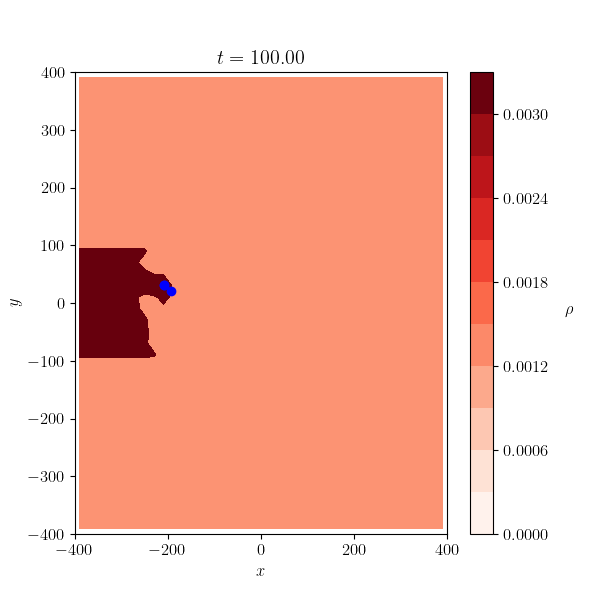

<ipython-input-66-bc8bb0c23b0e>:27: MatplotlibDeprecationWarning: 
The modification of the Axes.collections property was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use Artist.remove() instead.
  del ax.collections[:]
<ipython-input-66-bc8bb0c23b0e>:28: MatplotlibDeprecationWarning: 
The modification of the Axes.lines property was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use Artist.remove() instead.
  del ax.lines[:]


In [66]:
krem = 1
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%krem == 0]
agents = [agents_sol[i] for i in range(len(agents_sol)) if i%krem == 0]
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
ax.set_xlim(-L,L)
ax.set_ylim(-L,L)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
fig.canvas.draw()
ncont = 10
X,Y = solver.X, solver.Y
tspan = np.linspace(0,tmax,len(rho))
sc = ax.contourf(X,Y,rho[0],ncont,cmap = 'Reds',vmin = 1e-4,vmax = np.max(rho[0]))
cb = fig.colorbar(sc,ax = ax)
cb.set_label('$\\rho$',rotation = 0,labelpad = 15)
for y in agents[0]:
    ax.scatter(y[0],y[1], color = 'Blue')
for i in range(len(rho)):
    ax.contourf(X,Y,rho[i],ncont,cmap = 'Reds',vmin = 1e-4,vmax = np.max(rho[0]))
    ax.set_title('$t = %.2f$' % tspan[i])
    for y in agents[i]:
        ax.scatter(y[0],y[1], color = 'Blue')
    fig.canvas.draw()
    del ax.collections[:]
    del ax.lines[:]
ax.contourf(X,Y,rho[-1],ncont,cmap = 'Reds',vmin = 1e-4,vmax = np.max(rho[0]))
for y in agents[i]:
    ax.scatter(y[0],y[1], color = 'Blue')
plt.show()

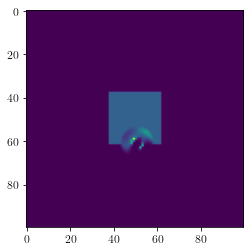

In [28]:
plt.imshow(solver.rho[-1])
plt.show()

<ipython-input-269-3939ccc7bb7e>:19: RuntimeWarning: invalid value encountered in true_divide
  h2 = (2*Fr/Rr*lin.norm(x) - 2*Fr)*x/lin.norm(x)*(lin.norm(x) < Rr)*(lin.norm(x) >= Rr/2)
<ipython-input-269-3939ccc7bb7e>:20: RuntimeWarning: invalid value encountered in true_divide
  h3 = -4*Fa*(lin.norm(x)-Rr)*(lin.norm(x)-Ra)*x/lin.norm(x)/(Rr-Ra)**2*(lin.norm(x) < Ra)*(lin.norm(x) > Rr)


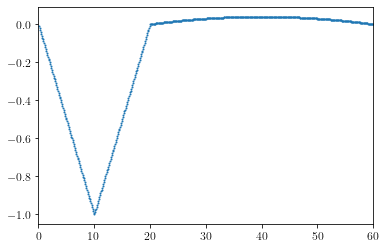

In [277]:
H = [H21(0,i)[1] for i in np.linspace(0,100,1000)]
plt.scatter(np.linspace(0,100,1000), H, s = 1)
plt.xlim(0,60)
plt.show()

In [260]:
agents

array([[[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,  

In [108]:
a = np.array([[1,2,3,4],[3,46,2,3]])
a[1:3,1:3] = [3,4]

In [109]:
a

array([[1, 2, 3, 4],
       [3, 3, 4, 3]])